<a href="https://colab.research.google.com/github/yashi-2004/CARDIAC-RISK-PREDICTION/blob/main/cardiac_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Load Data
import pandas as pd
from collections import Counter

df = pd.read_csv('CardiacP.csv')
df.drop(columns=['SEQN'], inplace=True)

X = df.drop(columns=['CoronaryHeartDisease'])
y = df['CoronaryHeartDisease']
print("Original:", Counter(y))

Original: Counter({0: 35571, 1: 1508})


In [2]:
# 2. Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)


In [3]:
# 3. Handle Class Imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_res))

After SMOTE: Counter({0: 24898, 1: 24898})


In [4]:

# 4. PyTorch NN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class CardiacNet(nn.Module):
    def __init__(self, input_dim):
        super(CardiacNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CardiacNet(X_train_res.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_tensor = torch.FloatTensor(X_train_res).to(device)
y_tensor = torch.FloatTensor(y_train_res.values).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1).to(device)

train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)



In [5]:
# 5. Training Loop
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')



for epoch in range(50):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # ➕ Train Accuracy Tracking
        preds = (out > 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor).cpu().numpy()
        val_loss = criterion(torch.tensor(val_pred), y_val_tensor.cpu()).item()
        val_losses.append(val_loss)

        val_preds_bin = (val_pred > 0.5).astype(int)
        val_acc = accuracy_score(y_val, val_preds_bin)
        val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    if epoch % 5 == 0:
        print(f"Epoch {epoch}")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")



Epoch 0
  Train Loss: 0.3983 | Train Acc: 0.8252
  Val Loss:   0.3937 | Val Acc:   0.8091
Epoch 5
  Train Loss: 0.2550 | Train Acc: 0.8954
  Val Loss:   0.2972 | Val Acc:   0.8596
Epoch 10
  Train Loss: 0.2102 | Train Acc: 0.9166
  Val Loss:   0.2696 | Val Acc:   0.8783
Epoch 15
  Train Loss: 0.1837 | Train Acc: 0.9301
  Val Loss:   0.2623 | Val Acc:   0.8939
Epoch 20
  Train Loss: 0.1716 | Train Acc: 0.9366
  Val Loss:   0.2689 | Val Acc:   0.8943
Epoch 25
  Train Loss: 0.1596 | Train Acc: 0.9410
  Val Loss:   0.2477 | Val Acc:   0.9047
Epoch 30
  Train Loss: 0.1489 | Train Acc: 0.9442
  Val Loss:   0.2588 | Val Acc:   0.9071
Epoch 35
  Train Loss: 0.1414 | Train Acc: 0.9478
  Val Loss:   0.2565 | Val Acc:   0.9080
Epoch 40
  Train Loss: 0.1368 | Train Acc: 0.9498
  Val Loss:   0.2584 | Val Acc:   0.9090
Epoch 45
  Train Loss: 0.1378 | Train Acc: 0.9493
  Val Loss:   0.2596 | Val Acc:   0.9063


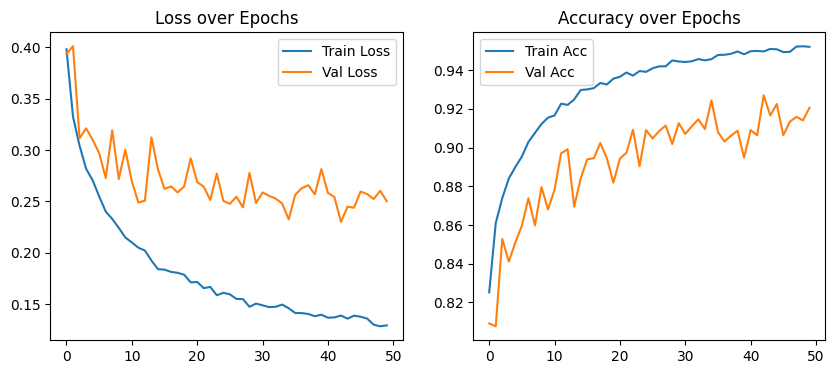

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [7]:
# 7. Evaluate on Test Set
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1).to(device)

with torch.no_grad():
    test_preds = model(X_test_tensor).cpu().numpy()
    test_bin = (test_preds > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, test_bin))
from sklearn.metrics import precision_score, recall_score, f1_score


print(classification_report(y_test, test_bin, digits=4))
print("ROC AUC:", roc_auc_score(y_test, test_preds))

Confusion Matrix:
 [[5076  260]
 [ 148   78]]
              precision    recall  f1-score   support

           0     0.9717    0.9513    0.9614      5336
           1     0.2308    0.3451    0.2766       226

    accuracy                         0.9266      5562
   macro avg     0.6012    0.6482    0.6190      5562
weighted avg     0.9416    0.9266    0.9335      5562

ROC AUC: 0.8363229889480037


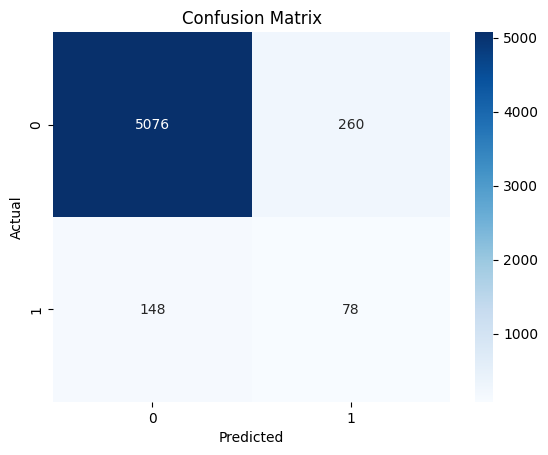

In [8]:
# 8. Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, test_bin), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

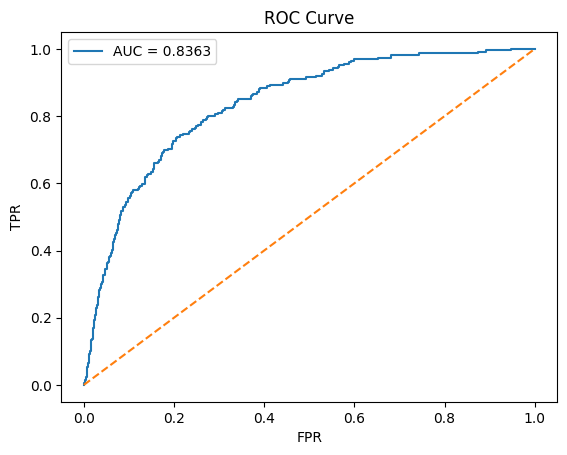

In [9]:
# 9. ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_preds)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()